In [305]:
import pandas as pd
act = pd.read_csv("D:/000-Master/Metropia_UserClustering/sample_activity_Oct-22-2018.csv")
act.rename(columns = {'Unnamed: 0':'index'},inplace=True)
loc = pd.read_csv("D:/000-Master/Metropia_UserClustering/sample_location_Oct-22-2018.csv")
loc.rename(columns = {'Unnamed: 0':'index'},inplace=True)
city_list = (dict(loc['city'].value_counts()))

act['start_date'] = act['local_start_time'].astype(str).str[:10]
act['local_start_time'] = act['local_start_time'].astype(str).str[:19]
act['local_start_time'] = pd.to_datetime(act['local_start_time'])
act['local_start_hour'] = act['local_start_time'].dt.hour

act['local_end_time'] = act['local_end_time'].astype(str).str[:19]
act['local_end_time'] = pd.to_datetime(act['local_end_time'])

import numpy as np
cols = ['loc_id','center_lat','center_lon']
df = loc[cols]

df.rename(columns = {'loc_id':'orig_loc_id'},inplace=True)
x = pd.merge(act, df, on="orig_loc_id")
x.rename(columns = {'center_lat':'orig_lat',
                   'center_lon':'orig_lon'},inplace=True)

df.rename(columns = {'orig_loc_id':'dest_loc_id'},inplace=True)
x = pd.merge(x, df, on="dest_loc_id")
x.rename(columns = {'center_lat':'dest_lat',
                   'center_lon':'dest_lon'},inplace=True)
act = x

from datetime import datetime, date, time
def weekday(data):
    dt = datetime.strptime(data, "%Y-%m-%d")
    tt = dt.timetuple()
    return tt[6]
    
act['day'] = (act['start_date']).apply(weekday) # weekday (0 = Monday)

act.head()

,index,trip_id,user_id,orig_loc_id,dest_loc_id,local_start_time,local_end_time,city,start_date,local_start_hour,orig_lat,orig_lon,dest_lat,dest_lon,day
0,1,2081071,16094,1,2,2018-03-14 12:07:18,2018-03-14 12:18:51,elpaso,2018-03-14,12,31.762442,-106.263962,31.775521,-106.308802,2
1,25,2159273,16094,1,2,2018-04-03 19:22:37,2018-04-03 19:38:30,elpaso,2018-04-03,19,31.762442,-106.263962,31.775521,-106.308802,1
2,71,2262622,16094,1,2,2018-04-28 11:21:08,2018-04-28 11:31:55,elpaso,2018-04-28,11,31.762442,-106.263962,31.775521,-106.308802,5
3,105,2352800,16094,1,2,2018-05-19 16:58:34,2018-05-19 17:11:17,elpaso,2018-05-19,16,31.762442,-106.263962,31.775521,-106.308802,5
4,110,2385335,16094,1,2,2018-05-28 14:03:31,2018-05-28 14:14:09,elpaso,2018-05-28,14,31.762442,-106.263962,31.775521,-106.308802,0


In [306]:
loc = loc.loc[loc['city'] == 'austin'] # Only one city 

### Convert into distance (km) ###
import math
O = [min(loc['center_lat']),min(loc['center_lon'])]
loc['center_x'] = (loc['center_lon']-O[1])*111.2*np.cos(np.radians(loc['center_lat'])) # x - lon - km
loc['center_y'] = (loc['center_lat']-O[0])*111.2 # y - lat - km
# loc.head()
data = loc.iloc[:,[1,10,11]]
print(data.shape)
data.head()

(906, 3)


,loc_id,center_x,center_y
0,6143,31.572641,46.776280
3,16290,36.171550,53.052519
8,17380,41.576696,58.450344
11,6157,35.822792,48.232222
13,9296,30.135049,58.339523


In [307]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

In [308]:
###  Genrate N colors (for differnt clusters) ###
def get_spaced_colors(n):
    max_value = 16581375 #255**3
    interval = int(max_value / n)
    colors = [hex(I)[2:].zfill(6) for I in range(0, max_value, interval)]
    
    return [(int(i[:2], 16)/255, int(i[2:4], 16)/255, int(i[4:], 16)/255) for i in colors]

# get_spaced_colors(2)

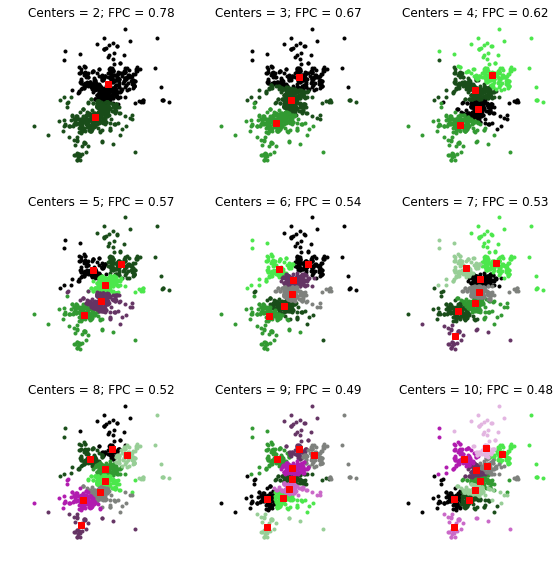

In [189]:
### Try different Parameters(# of centers) ###
fig1, axes1 = plt.subplots(3, 3, figsize=(8, 8))

colors = get_spaced_colors(10)
fpcs = [] # list storing FPCs. The FPC is defined on the range from 0 to 1, with 1 indicating the best model

xpts = data['center_x']
ypts = data['center_y']
alldata = np.vstack((xpts, ypts))

for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        alldata, ncenters, 2, error=0.005, maxiter=1000, init=None) #https://pythonhosted.org/scikit-fuzzy/api/skfuzzy.cluster.html

    # Store fpc values for later
    fpcs.append(fpc)

    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(xpts[cluster_membership == j],
                ypts[cluster_membership == j], '.', color=colors[j])

    # Mark the center of each fuzzy cluster
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
    ax.axis('off')

fig1.tight_layout()

In [309]:
### Clustering location id####
ncenters = 150 # Needs to be tried several times
xpts = data['center_x']
ypts = data['center_y']
alldata = np.vstack((xpts, ypts))
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        alldata, ncenters, 2, error=0.005, maxiter=1000, init=None) #https://pythonhosted.org/scikit-fuzzy/api/skfuzzy.cluster.html

In [310]:
### Overlapping Labels for Locations ###
from heapq import nlargest
from sklearn.neighbors import KNeighborsClassifier
N_4 = []
N_4_index = []
for i in range(0,(len(u[0]))): 
        N_4.append(list(nlargest(4, u[:,i])))
        N_4_index.append(list(u[:,i].argsort()[-4:][::-1]))

N_4 = pd.DataFrame(N_4)
N_4_index = pd.DataFrame(N_4_index)

In [341]:
labels = {'label_1':N_4_index[0], 'label_2':np.nan ,'label_3':np.nan,'label_4':np.nan}
labels = pd.DataFrame(labels)
for i in range(0,len(N_4)):
    if(N_4.at[i,0] - N_4.at[i,1] <= 0.1): # if diff < 0.1
        labels.at[i,'label_2'] = N_4_index.at[i,1]
        if(N_4.at[i,1] - N_4.at[i,2] <= 0.1):
            labels.at[i,'label_3'] = N_4_index.at[i,2]
            if(N_4.at[i,2] - N_4.at[i,3] <= 0.1):
                labels.at[i,'label_4'] = N_4_index.at[i,3]
data = loc.iloc[:,[1,10,11]]
data['label_1'] = labels['label_1'].values
data['label_2'] = labels['label_2'].values
data['label_3'] = labels['label_3'].values
data['label_4'] = labels['label_4'].values
# data.head()

### Add Location Labels to Each Trip ###
data.rename(columns = {'loc_id':'orig_loc_id','label_1':'ori_1','label_2':'ori_2','label_3':'ori_3','label_4':'ori_4'},inplace=True)
act_label = pd.merge(act[['user_id','orig_loc_id','dest_loc_id','local_start_hour','day']], data[['orig_loc_id','ori_1','ori_2','ori_3','ori_4']], on='orig_loc_id')

data.rename(columns = {'orig_loc_id':'dest_loc_id','ori_1':'dest_1','ori_2':'dest_2','ori_3':'dest_3','ori_4':'dest_4'},inplace=True)
act_label = pd.merge(act_label, data[['dest_loc_id','dest_1','dest_2','dest_3','dest_4']], on="dest_loc_id")

bins = [0,6,12,19,24] ### bin hours
hour_label = [1,2,3,4]
act_label['start_hour_bin'] = pd.cut(act_label['local_start_hour'], bins=bins, labels=hour_label)

### Calculate Frequency for Each OD ####
temp = act_label.groupby(['user_id','orig_loc_id','dest_loc_id']).size().reset_index(name="count")

temp = pd.merge(temp, act_label.groupby(['user_id']).size().reset_index(name="sum"), on = "user_id")
temp['frequency'] = temp['count']/temp['sum']
temp = temp.drop(['count','sum'], 1)
temp = pd.merge(act_label, temp, on = ['user_id','orig_loc_id','dest_loc_id'])
temp.head()

act_label = temp
act_label.head()

d:\download\python\py\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
d:\download\python\py\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
d:\download\python\py\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

,user_id,orig_loc_id,dest_loc_id,local_start_hour,day,ori_1,ori_2,ori_3,ori_4,dest_1,dest_2,dest_3,dest_4,start_hour_bin,frequency
0,4134,204,202,16,3,130,97.0,52.0,59.0,10,41.0,NaN,NaN,3,0.076923
1,4134,204,202,16,4,130,97.0,52.0,59.0,10,41.0,NaN,NaN,3,0.076923
2,4134,204,202,16,2,130,97.0,52.0,59.0,10,41.0,NaN,NaN,3,0.076923
3,4134,204,202,16,2,130,97.0,52.0,59.0,10,41.0,NaN,NaN,3,0.076923
4,4134,204,202,16,0,130,97.0,52.0,59.0,10,41.0,NaN,NaN,3,0.076923


In [342]:
act_label['id_1'] = pd.Categorical(act_label['start_hour_bin'].astype(str) + '_' + act_label['ori_1'].astype(str) + '_' + act_label['dest_1'].astype(str)).codes
act_label['id_2'] = pd.Categorical(act_label['start_hour_bin'].astype(str) + '_' + act_label['ori_1'].astype(str) + '_' + act_label['dest_2'].astype(str)).codes
act_label['id_3'] = pd.Categorical(act_label['start_hour_bin'].astype(str) + '_' + act_label['ori_1'].astype(str) + '_' + act_label['dest_3'].astype(str)).codes
act_label['id_4'] = pd.Categorical(act_label['start_hour_bin'].astype(str) + '_' + act_label['ori_1'].astype(str) + '_' + act_label['dest_4'].astype(str)).codes

act_label['id_5'] = pd.Categorical(act_label['start_hour_bin'].astype(str) + '_' + act_label['ori_2'].astype(str) + '_' + act_label['dest_1'].astype(str)).codes
act_label['id_6'] = pd.Categorical(act_label['start_hour_bin'].astype(str) + '_' + act_label['ori_2'].astype(str) + '_' + act_label['dest_2'].astype(str)).codes
act_label['id_7'] = pd.Categorical(act_label['start_hour_bin'].astype(str) + '_' + act_label['ori_2'].astype(str) + '_' + act_label['dest_3'].astype(str)).codes
act_label['id_8'] = pd.Categorical(act_label['start_hour_bin'].astype(str) + '_' + act_label['ori_2'].astype(str) + '_' + act_label['dest_4'].astype(str)).codes

act_label['id_9'] = pd.Categorical(act_label['start_hour_bin'].astype(str) + '_' + act_label['ori_3'].astype(str) + '_' + act_label['dest_1'].astype(str)).codes
act_label['id_10'] = pd.Categorical(act_label['start_hour_bin'].astype(str) + '_' + act_label['ori_3'].astype(str) + '_' + act_label['dest_2'].astype(str)).codes
act_label['id_11'] = pd.Categorical(act_label['start_hour_bin'].astype(str) + '_' + act_label['ori_3'].astype(str) + '_' + act_label['dest_3'].astype(str)).codes
act_label['id_12'] = pd.Categorical(act_label['start_hour_bin'].astype(str) + '_' + act_label['ori_3'].astype(str) + '_' + act_label['dest_4'].astype(str)).codes

act_label['id_13'] = pd.Categorical(act_label['start_hour_bin'].astype(str) + '_' + act_label['ori_4'].astype(str) + '_' + act_label['dest_1'].astype(str)).codes
act_label['id_14'] = pd.Categorical(act_label['start_hour_bin'].astype(str) + '_' + act_label['ori_4'].astype(str) + '_' + act_label['dest_2'].astype(str)).codes
act_label['id_15'] = pd.Categorical(act_label['start_hour_bin'].astype(str) + '_' + act_label['ori_4'].astype(str) + '_' + act_label['dest_3'].astype(str)).codes
act_label['id_16'] = pd.Categorical(act_label['start_hour_bin'].astype(str) + '_' + act_label['ori_4'].astype(str) + '_' + act_label['dest_4'].astype(str)).codes

# act_label['id_2'].iloc[act_label['dest_2'] = np.nan] = np.nan

act_label['id_2'] = np.where((act_label['dest_2'].isnull()), np.nan, act_label['id_2'])
act_label['id_3'] = np.where((act_label['dest_3'].isnull()), np.nan, act_label['id_3'])
act_label['id_4'] = np.where((act_label['dest_4'].isnull()), np.nan, act_label['id_4'])

act_label['id_5'] = np.where((act_label['ori_2'].isnull()), np.nan, act_label['id_5'])
act_label['id_6'] = np.where((act_label['dest_2'].isnull()), np.nan, act_label['id_6'])
act_label['id_6'] = np.where((act_label['ori_2'].isnull()), np.nan, act_label['id_6'])
act_label['id_7'] = np.where((act_label['dest_3'].isnull()), np.nan, act_label['id_7'])
act_label['id_7'] = np.where((act_label['ori_2'].isnull()), np.nan, act_label['id_7'])
act_label['id_8'] = np.where((act_label['dest_4'].isnull()), np.nan, act_label['id_8'])
act_label['id_8'] = np.where((act_label['ori_2'].isnull()), np.nan, act_label['id_8'])

act_label['id_9'] = np.where((act_label['ori_3'].isnull()), np.nan, act_label['id_9'])
act_label['id_10'] = np.where((act_label['dest_2'].isnull()), np.nan, act_label['id_10'])
act_label['id_10'] = np.where((act_label['ori_3'].isnull()), np.nan, act_label['id_10'])
act_label['id_11'] = np.where((act_label['dest_3'].isnull()), np.nan, act_label['id_11'])
act_label['id_11'] = np.where((act_label['ori_3'].isnull()), np.nan, act_label['id_11'])
act_label['id_12'] = np.where((act_label['dest_4'].isnull()), np.nan, act_label['id_12'])
act_label['id_12'] = np.where((act_label['ori_3'].isnull()), np.nan, act_label['id_12'])

act_label['id_13'] = np.where((act_label['ori_4'].isnull()), np.nan, act_label['id_13'])
act_label['id_14'] = np.where((act_label['dest_2'].isnull()), np.nan, act_label['id_14'])
act_label['id_10'] = np.where((act_label['ori_4'].isnull()), np.nan, act_label['id_14'])
act_label['id_15'] = np.where((act_label['dest_3'].isnull()), np.nan, act_label['id_15'])
act_label['id_15'] = np.where((act_label['ori_4'].isnull()), np.nan, act_label['id_15'])
act_label['id_16'] = np.where((act_label['dest_4'].isnull()), np.nan, act_label['id_16'])
act_label['id_16'] = np.where((act_label['ori_4'].isnull()), np.nan, act_label['id_16'])

user_label = act_label[['user_id','id_1','id_2','id_3','id_4','id_5','id_6','id_7','id_8','id_9','id_10','id_11','id_12','id_13','id_14','id_15','id_16']]
user_label.head()

,user_id,id_1,id_2,id_3,id_4,id_5,id_6,id_7,id_8,id_9,id_10,id_11,id_12,id_13,id_14,id_15,id_16
0,4134,749,435.0,NaN,NaN,537.0,341.0,NaN,NaN,470.0,288.0,NaN,NaN,460.0,288.0,NaN,NaN
1,4134,749,435.0,NaN,NaN,537.0,341.0,NaN,NaN,470.0,288.0,NaN,NaN,460.0,288.0,NaN,NaN
2,4134,749,435.0,NaN,NaN,537.0,341.0,NaN,NaN,470.0,288.0,NaN,NaN,460.0,288.0,NaN,NaN
3,4134,749,435.0,NaN,NaN,537.0,341.0,NaN,NaN,470.0,288.0,NaN,NaN,460.0,288.0,NaN,NaN
4,4134,749,435.0,NaN,NaN,537.0,341.0,NaN,NaN,470.0,288.0,NaN,NaN,460.0,288.0,NaN,NaN


In [343]:
data.rename(columns = {'dest_loc_id':'loc_id','dest_1':'label_1','dest_2':'label_2','dest_3':'label_3','dest_4':'label_4'},inplace=True)
data.head()

,loc_id,center_x,center_y,label_1,label_2,label_3,label_4
0,6143,31.572641,46.776280,118,NaN,NaN,NaN
3,16290,36.171550,53.052519,106,55.0,50.0,109.0
8,17380,41.576696,58.450344,143,NaN,NaN,NaN
11,6157,35.822792,48.232222,30,NaN,NaN,NaN
13,9296,30.135049,58.339523,95,139.0,57.0,115.0


In [374]:
### Evaluation ###
### 1. Distance Matrix ###
max_dist = [] # maximum within-group distance of group j
avg_dist = [] # average distance
j = 0
for i in set(data['label_1']).intersection(set(act_label['ori_1'])):    
    one = data.loc[data['label_1'] == i]
    one_1 = one.loc[one.index.repeat(len(one))].reset_index(drop=True) # reset index
    one_2 = one
    one_2 = pd.concat([one_2]*len(one_2), ignore_index=True)
    one_2.rename(columns = {'loc_id':'loc_id_2','center_y': 'center_y_2','center_x':'center_x_2'},inplace=True)
    one_3 = one_1.join(one_2, lsuffix='_one_1', rsuffix='_one_2') # IMPORTANT!!!
    from sklearn.metrics.pairwise import pairwise_distances 
    from sklearn.cluster import DBSCAN 
    from geopy.distance import vincenty
    # unit in km
    one_3['distance'] = np.sqrt(np.square(one_3['center_y']-one_3['center_y_2'])+np.square(one_3['center_x']-one_3['center_x_2']))
    one_distance_matrix = one_3.pivot_table(index=['loc_id'],columns=['loc_id_2'],values='distance')
    max_dist.append(one_distance_matrix.values.max())
    avg_dist.append(one_distance_matrix.values.mean())
    j = j + 1

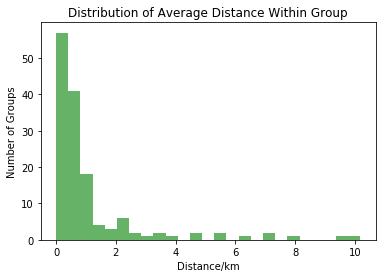

In [375]:
max_dist = pd.DataFrame(max_dist) # max distance winthin group
max_dist.columns = ['distance']
max_dist.head()
avg_dist = pd.DataFrame(avg_dist) # average distance within group
avg_dist.columns = ['distance']
avg_dist.head()

plt.hist(avg_dist['distance'], bins=25, alpha=0.6, color='g') #hist 
title = "Distribution of Average Distance Within Group"
plt.xlabel("Distance/km")
plt.ylabel("Number of Groups")
plt.title(title)
plt.show()

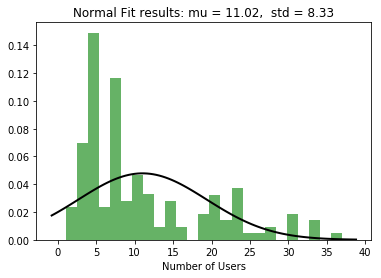

In [346]:
### 2. # of users in a group ###
# Goal: balanced number of users in each group
count_users = pd.DataFrame(labels.stack().value_counts())
count_users = count_users.iloc[1:]
count_users.columns = ['num']
# count_users.head()
# count_users.shape

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

mu, std = norm.fit(count_users['num'])
plt.hist(count_users['num'], bins=25, density=True, alpha=0.6, color='g') #hist 
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std) # pdf
plt.plot(x, p, 'k', linewidth=2)
title = "Normal Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.xlabel("Number of Users")
# plt.ylabel("Frequency")
plt.show()

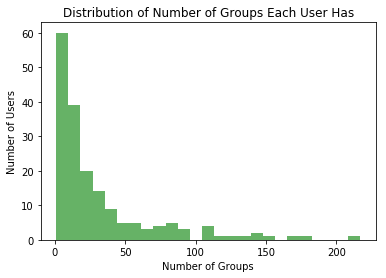

In [367]:
### 3. # of groups a user have ####
num_groups = act_label.groupby(['user_id'])[['id_1','id_2','id_3','id_4','id_5','id_6','id_7','id_8','id_9','id_10','id_11','id_12','id_13','id_14','id_15','id_16']].nunique()
num_groups['sum'] = num_groups.sum(axis = 1)

plt.hist(num_groups['sum'], bins=25, alpha=0.6, color='g') #hist 
title = "Distribution of Number of Groups Each User Has"
plt.xlabel("Number of Groups")
plt.ylabel("Number of Users")
plt.title(title)
plt.show()

In [370]:
### User Ranking (5 groups/user) ####
wkn_act = act_label[(act_label['day'] >=5 )]
wkn_act = wkn_act.sort_values(['user_id','frequency'],ascending=False).groupby('user_id').head(5)

wkd_act = act_label[(act_label['day'] < 5 )]
wkd_act = wkd_act.sort_values(['user_id','frequency'],ascending=False).groupby('user_id').head(5)

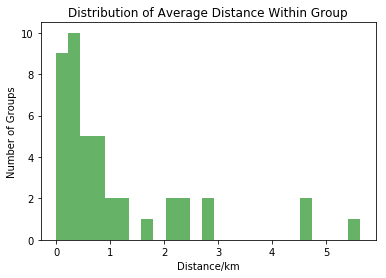

In [373]:
### Weekday
### EVL1 ####
max_dist = [] # maximum within-group distance of group j
avg_dist = [] # average distance
j = 0
for i in set(data['label_1']).intersection(set(wkd_act['ori_1'])):    
    one = data.loc[data['label_1'] == i]
    one_1 = one.loc[one.index.repeat(len(one))].reset_index(drop=True) # reset index
    one_2 = one
    one_2 = pd.concat([one_2]*len(one_2), ignore_index=True)
    one_2.rename(columns = {'loc_id':'loc_id_2','center_y': 'center_y_2','center_x':'center_x_2'},inplace=True)
    one_3 = one_1.join(one_2, lsuffix='_one_1', rsuffix='_one_2') # IMPORTANT!!!
    from sklearn.metrics.pairwise import pairwise_distances 
    from sklearn.cluster import DBSCAN 
    from geopy.distance import vincenty
    # unit in km
    one_3['distance'] = np.sqrt(np.square(one_3['center_y']-one_3['center_y_2'])+np.square(one_3['center_x']-one_3['center_x_2']))
    one_distance_matrix = one_3.pivot_table(index=['loc_id'],columns=['loc_id_2'],values='distance')
    max_dist.append(one_distance_matrix.values.max())
    avg_dist.append(one_distance_matrix.values.mean())
    j = j + 1

max_dist = pd.DataFrame(max_dist) # max distance winthin group
max_dist.columns = ['distance']
max_dist.head()
avg_dist = pd.DataFrame(avg_dist) # average distance within group
avg_dist.columns = ['distance']
avg_dist.head()

plt.hist(avg_dist['distance'], bins=25, alpha=0.6, color='g') #hist 
title = "Distribution of Average Distance Within Group"
plt.xlabel("Distance/km")
plt.ylabel("Number of Groups")
plt.title(title)
plt.show()

### ELV2 ####
count_users = pd.DataFrame(labels.stack().value_counts())
count_users = count_users.iloc[1:]
count_users.columns = ['num']

# count_users.head()
# count_users.shape

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

mu, std = norm.fit(count_users['num'])
plt.hist(count_users['num'], bins=25, density=True, alpha=0.6, color='g') #hist 
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std) # pdf
plt.plot(x, p, 'k', linewidth=2)
title = "Normal Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.xlabel("Number of Users")
# plt.ylabel("Frequency")
plt.show()